### Messing around with plots
This works best for my by running
`jupyter notebook viz_exploratory` from command line
and ensuring that the same file is NOT open in pycharm.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator
from data import dbclient, daily_case_data_by_zip, data_transformations
from data.socrata import socrata_api_requests, soda_data
import build_db

#imports specifically for the interactive mapping
import pandas as pd
import geopandas as gpd
import json
from bokeh.io import show
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure

In [3]:
db = dbclient.DBClient()
zipcode_to_test = '60637'
sql_table_name = soda_data.VACCINATION_DATA_OBJ.sql_table_name
query = f"select {data_transformations.STD_ZIP_COL_NAME}, {data_transformations.STD_DATE_COL_NAME}, AVG7DAY_total_doses_daily from {sql_table_name} where {data_transformations.STD_ZIP_COL_NAME} = '{zipcode_to_test}'"
print(f"query = {query}")
zipcode_vax_weekly = pd.read_sql_query(query, db.conn)
zipcode_vax_weekly.tail()

query = select ZIPCODE, STD_DATE, AVG7DAY_total_doses_daily from VACCINATIONS where ZIPCODE = '60637'


,ZIPCODE,STD_DATE,AVG7DAY_total_doses_daily
79,60637,2021-03-04 00:00:00,149.571429
80,60637,2021-03-05 00:00:00,144.000000
81,60637,2021-03-06 00:00:00,143.285714
82,60637,2021-03-07 00:00:00,133.000000
83,60637,2021-03-08 00:00:00,123.428571


### matplotlib

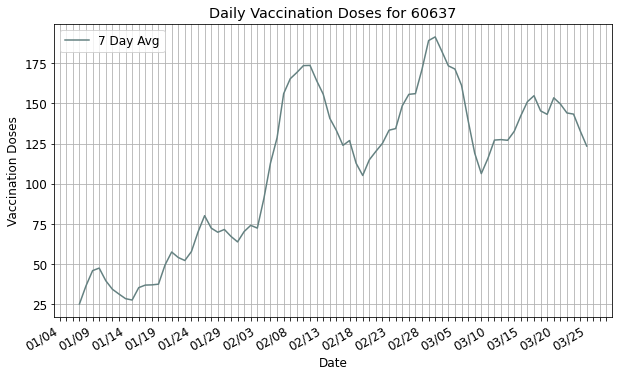

In [4]:
%matplotlib inline

title_str = f"Daily Vaccination Doses for {zipcode_to_test}"
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

# Specify how our lines should look
ax.plot(zipcode_vax_weekly[data_transformations.STD_DATE_COL_NAME],
        zipcode_vax_weekly.AVG7DAY_total_doses_daily, color='#648181', linestyle='solid', label='7 Day Avg')

ax.set_xlabel('Date')
ax.set_ylabel('Vaccination Doses')
ax.set_title(title_str)
ax.grid(True)
ax.legend(loc='upper left');
ax.xaxis.set_major_locator(DayLocator())
ax.xaxis.set_major_formatter(DateFormatter('%m/%d'))

every_nth = 5
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
        
fig.autofmt_xdate()

### Interactive Mapping
building an interactive map of Chicago zips with bokeh and Geopandas
shapely file from https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-ZIP-Codes/gdcf-axmw

In [5]:
chicago = gpd.read_file('view/data/zip_shp_dir/geo_chicago.shp')
print(chicago.columns)
print(len(chicago))
print(chicago.dtypes)
chicago.head()

Index(['objectid', 'shape_area', 'shape_len', 'zip', 'geometry'], dtype='object')
61
objectid       float64
shape_area     float64
shape_len      float64
zip             object
geometry      geometry
dtype: object


,objectid,shape_area,shape_len,zip,geometry
0,33.0,1.060523e+08,42720.044406,60647,"POLYGON ((-87.67762 41.91776, -87.67761 41.917..."
1,34.0,1.274761e+08,48103.782721,60639,"POLYGON ((-87.72683 41.92265, -87.72693 41.922..."
2,35.0,4.506904e+07,27288.609612,60707,"POLYGON ((-87.78500 41.90915, -87.78531 41.909..."
3,36.0,7.085383e+07,42527.989679,60622,"POLYGON ((-87.66707 41.88885, -87.66707 41.888..."
4,37.0,9.903962e+07,47970.140153,60651,"POLYGON ((-87.70656 41.89555, -87.70672 41.895..."


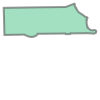

In [6]:
chicago.iloc[9]['geometry'] # name that zip code

In [7]:
census_table_name = build_db.CENSUS_TBL
census_query = f"select * from {census_table_name}"
print(f"query = {query}")
census_df = pd.read_sql_query(census_query, db.conn)
print(census_df.dtypes)
print(len(census_df))
census_df.head()

query = select ZIPCODE, STD_DATE, AVG7DAY_total_doses_daily from VACCINATIONS where ZIPCODE = '60637'
index                      int64
zcta                      object
hhold_size               float64
fam_size                 float64
unemploy_rate            float64
median_income              int64
pct_below_poverty_lvl    float64
median_age               float64
pct_65_or_older          float64
pct_hispanic             float64
pct_asian                float64
pct_black                float64
pct_white                float64
pct_pacific_islander     float64
pct_american_indian      float64
pct_other_race           float64
pct_high_school_grad     float64
pct_hholds_w_computer    float64
pct_hholds_w_internet    float64
pct_w_health_insur       float64
state                      int64
ZIPCODE                   object
dtype: object
58


,index,zcta,hhold_size,fam_size,unemploy_rate,median_income,pct_below_poverty_lvl,median_age,pct_65_or_older,pct_hispanic,...,pct_white,pct_pacific_islander,pct_american_indian,pct_other_race,pct_high_school_grad,pct_hholds_w_computer,pct_hholds_w_internet,pct_w_health_insur,state,ZIPCODE
0,0,ZCTA5 60604,1.64,2.30,5.7,91750,9.1,32.2,8.7,3.4,...,62.5,0.0,0.0,0.0,0.0,100.0,91.8,99.5,17,60604
1,1,ZCTA5 60612,2.39,3.43,6.2,43545,23.2,32.5,9.9,12.0,...,22.6,0.0,0.0,0.1,23.0,84.0,70.9,93.7,17,60612
2,2,ZCTA5 60613,1.86,2.75,2.4,84318,3.7,33.6,9.7,11.1,...,73.0,0.0,0.0,0.1,7.7,94.2,88.4,94.8,17,60613
3,3,ZCTA5 60617,2.89,3.65,8.5,41125,19.3,36.0,15.1,37.2,...,5.9,0.0,0.1,0.1,32.5,83.1,78.1,91.5,17,60617
4,4,ZCTA5 60618,2.67,3.35,2.6,78704,8.0,34.4,9.2,40.3,...,48.0,0.1,0.1,0.3,18.0,92.4,83.6,87.0,17,60618


In [8]:
#merge our census data set with the geo dataset
geo_plus_census = chicago.merge(census_df, left_on = 'zip', right_on = 'ZIPCODE')
print(len(geo_plus_census))
geo_plus_census.head()

60


,objectid,shape_area,shape_len,zip,geometry,index,zcta,hhold_size,fam_size,unemploy_rate,...,pct_white,pct_pacific_islander,pct_american_indian,pct_other_race,pct_high_school_grad,pct_hholds_w_computer,pct_hholds_w_internet,pct_w_health_insur,state,ZIPCODE
0,33.0,1.060523e+08,42720.044406,60647,"POLYGON ((-87.67762 41.91776, -87.67761 41.917...",44,ZCTA5 60647,2.46,3.27,3.1,...,46.3,0.0,0.0,0.1,19.4,88.2,82.8,90.2,17,60647
1,34.0,1.274761e+08,48103.782721,60639,"POLYGON ((-87.72683 41.92265, -87.72693 41.922...",42,ZCTA5 60639,3.43,3.96,4.9,...,7.5,0.0,0.1,0.3,31.0,84.8,71.7,83.2,17,60639
2,35.0,4.506904e+07,27288.609612,60707,"POLYGON ((-87.78500 41.90915, -87.78531 41.909...",14,ZCTA5 60707,2.79,3.49,3.9,...,48.2,0.0,0.3,0.4,29.0,88.0,78.5,90.8,17,60707
3,51.0,3.450671e+06,7909.890407,60707,"POLYGON ((-87.80662 41.93451, -87.80686 41.934...",14,ZCTA5 60707,2.79,3.49,3.9,...,48.2,0.0,0.3,0.4,29.0,88.0,78.5,90.8,17,60707
4,36.0,7.085383e+07,42527.989679,60622,"POLYGON ((-87.66707 41.88885, -87.66707 41.888...",52,ZCTA5 60622,2.22,2.95,2.1,...,64.2,0.1,0.1,0.2,10.6,92.6,88.9,94.4,17,60622


In [9]:
# Input GeoJSON source that contains features for plotting
geosource = GeoJSONDataSource(geojson = geo_plus_census.to_json())

# Define color palettes
palette = brewer['BuGn'][8]
palette = palette[::-1] # reverse order of colors so higher values have darker colors
# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 10)
# Define custom tick labels for color bar.
tick_labels = {'0': '0', '1': '1',
 '2':'2', '3':'3',
 '4':'4', '5':'5',
 '6':'6', '7':'7',
 '8':'8+'}
# Create color bar.
color_bar = ColorBar(color_mapper = color_mapper,
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     major_label_overrides = tick_labels)

# Create figure object.
p = figure(title = 'Test Chicago Zipcode Demographics map',
           plot_height = 700, # these dimensions need some fine-tuning
           plot_width = 700,
           toolbar_location = 'below',
           tools = 'pan, wheel_zoom, box_zoom, reset')
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.
zips = p.patches('xs','ys', source = geosource,
                 fill_color = {'field' :'unemploy_rate',
                                 'transform' : color_mapper},
                 line_color = 'gray', 
                 line_width = 0.25,
                 fill_alpha = 1)
# Create hover tool
p.add_tools(HoverTool(renderers = [zips],
                      tooltips = [('Zipcode','@ZIPCODE'),
                                ('Unemploy. rate','@unemploy_rate')]))
show(p)